# Data Access

In [1]:
import numpy as np
import matplotlib.image as mpimg
import os
from os import listdir
from os.path import isfile, join
from random import sample
from google.colab import drive
from tqdm.notebook import tqdm
from keras.utils.np_utils import to_categorical   

In [2]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
X_train = []
y_train = []
bird_types = ['AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 
              'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART']
for i, b in enumerate(bird_types):
  print("Bird type:", b)
  mypath = './gdrive/My Drive/birds/train/' + b + "/"
  onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
  for f in tqdm(onlyfiles):
    x = mpimg.imread(mypath + f) / 255.
    X_train.append(x)
    y_train.append(i)

Bird type: AFRICAN FIREFINCH



Bird type: ALBATROSS



Bird type: ALEXANDRINE PARAKEET



Bird type: AMERICAN AVOCET



Bird type: AMERICAN BITTERN



Bird type: AMERICAN COOT



Bird type: AMERICAN GOLDFINCH



Bird type: AMERICAN KESTREL



Bird type: AMERICAN PIPIT



Bird type: AMERICAN REDSTART


In [3]:
X_test = []
y_test = []
bird_types = ['AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 
              'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART']
for i, b in enumerate(bird_types):
  print("Bird type:", b)
  mypath = './gdrive/My Drive/birds/test/' + b + "/"
  onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
  for f in tqdm(onlyfiles):
    x = mpimg.imread(mypath + f) / 255.
    X_test.append(x)
    y_test.append(i)

Bird type: AFRICAN FIREFINCH



Bird type: ALBATROSS



Bird type: ALEXANDRINE PARAKEET



Bird type: AMERICAN AVOCET



Bird type: AMERICAN BITTERN



Bird type: AMERICAN COOT



Bird type: AMERICAN GOLDFINCH



Bird type: AMERICAN KESTREL



Bird type: AMERICAN PIPIT



Bird type: AMERICAN REDSTART


In [7]:
X_valid = []
y_valid = []
bird_types = ['AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 
              'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART']
for i, b in enumerate(bird_types):
  print("Bird type:", b)
  mypath = './gdrive/My Drive/birds/valid/' + b + "/"
  onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
  for f in tqdm(onlyfiles):
    x = mpimg.imread(mypath + f) / 255.
    X_valid.append(x)
    y_valid.append(i)

Bird type: AFRICAN FIREFINCH


NameError: ignored

In [ ]:
X_train=np.asarray(X_train)/255
y_train=np.asarray(y_train).reshape(-1,1)
y_train_cat = to_categorical(y_train, num_classes=10)
print((X_train.shape,y_train_cat.shape))

((1526, 224, 224, 3), (1526, 10))


In [ ]:
X_test = np.asarray(X_test)/255
y_test = np.asarray(y_test).reshape(-1,1)
y_test_cat = to_categorical(y_test, num_classes=10)
print((X_test.shape,y_test_cat.shape))

((50, 224, 224, 3), (50, 10))


In [ ]:
X_valid = np.asarray(X_valid)/255
y_valid = np.asarray(y_valid).reshape(-1,1)
y_valid_cat = to_categorical(y_valid, num_classes=10)
print((X_valid.shape,y_valid_cat.shape))

((50, 224, 224, 3), (50, 10))


# CAM

In [4]:
from tensorflow import keras
import tensorflow as tf
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [5]:
# use pretrained Xception as visualized model
model_builder = keras.applications.xception.Xception
img_size = (244, 244)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

In [6]:
model = model_builder(weights="imagenet")
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [7]:
# choose the visualized layer
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]

In [16]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
  # create a model for mapping input image to the choosen layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

  # create a model for mapping input image to predition
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

  # compute the gradient of the prediction
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # add gradient to each visualizaiton layer
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]


    heatmap = np.mean(last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


## Heatmap

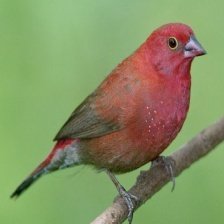

Predicted: [('n01532829', 'house_finch', 0.5093662)]


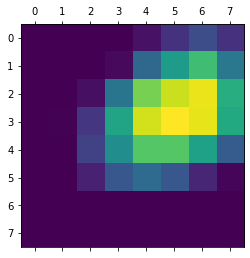

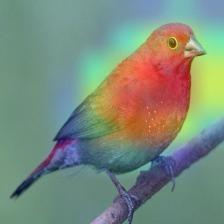

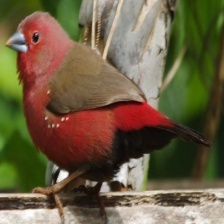

Predicted: [('n01531178', 'goldfinch', 0.34690505)]


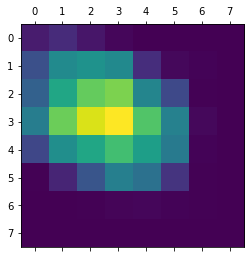

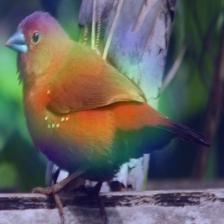

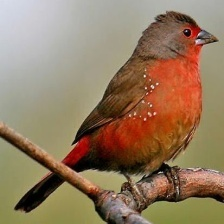

Predicted: [('n01532829', 'house_finch', 0.84473664)]


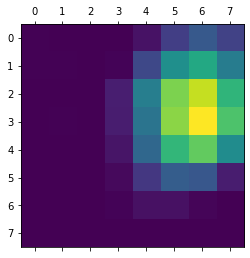

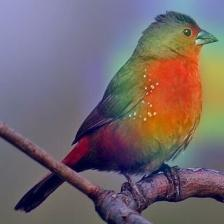

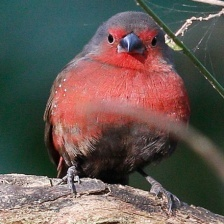

Predicted: [('n01530575', 'brambling', 0.42947286)]


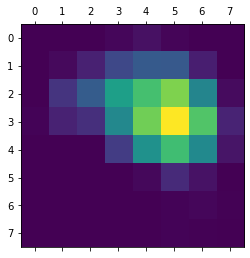

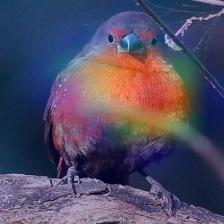

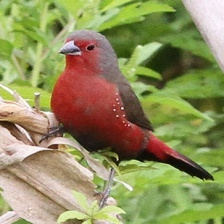

Predicted: [('n01807496', 'partridge', 0.3508505)]


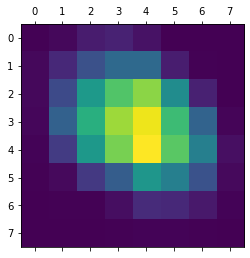

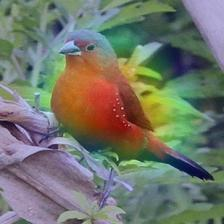

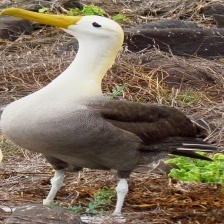

Predicted: [('n02058221', 'albatross', 0.9985952)]


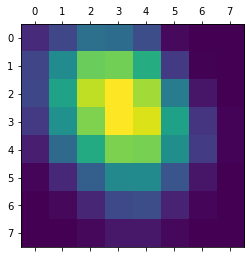

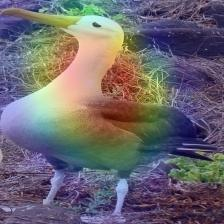

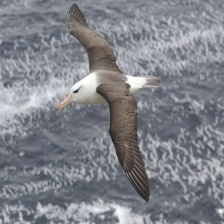

Predicted: [('n02058221', 'albatross', 0.99992156)]


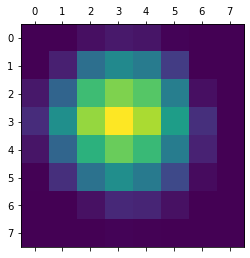

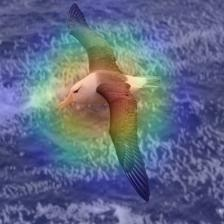

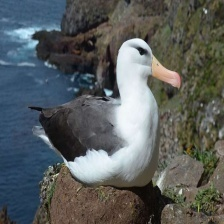

Predicted: [('n02058221', 'albatross', 0.997221)]


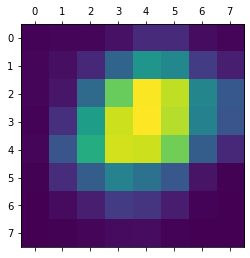

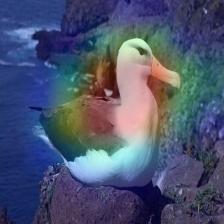

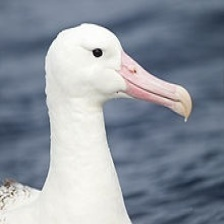

Predicted: [('n02058221', 'albatross', 0.99851173)]


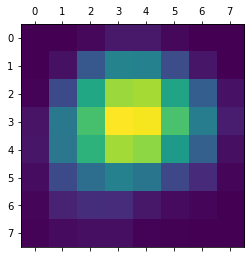

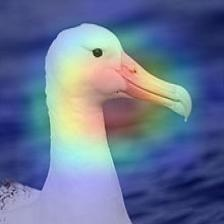

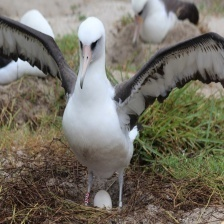

Predicted: [('n02058221', 'albatross', 0.9992867)]


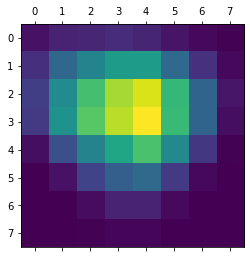

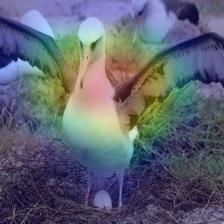

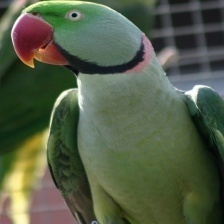

Predicted: [('n01820546', 'lorikeet', 0.5449598)]


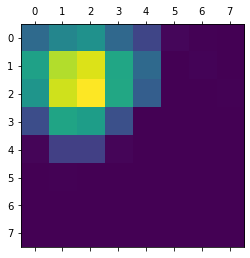

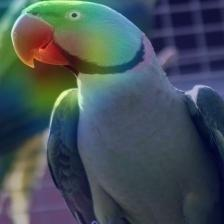

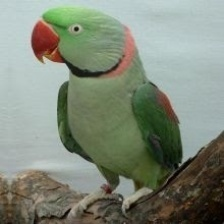

Predicted: [('n01820546', 'lorikeet', 0.79325664)]


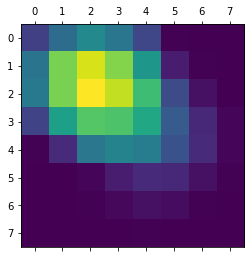

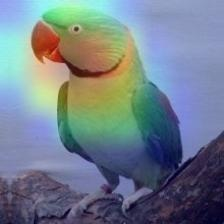

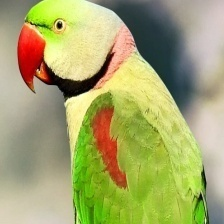

Predicted: [('n01820546', 'lorikeet', 0.8970356)]


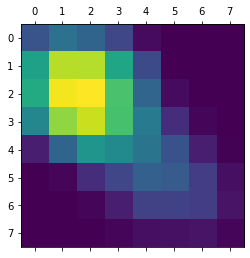

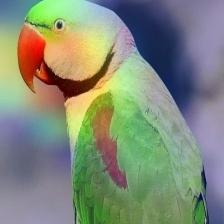

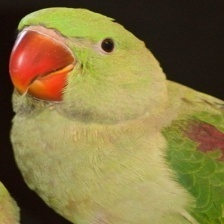

Predicted: [('n01820546', 'lorikeet', 0.8281915)]


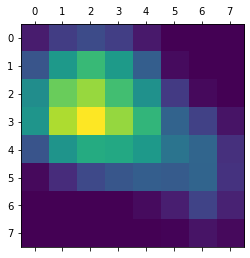

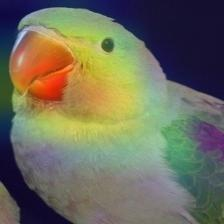

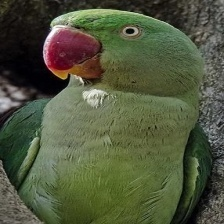

Predicted: [('n01820546', 'lorikeet', 0.91143817)]


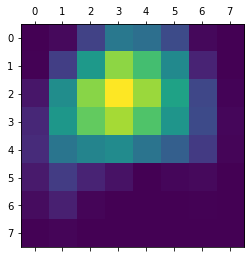

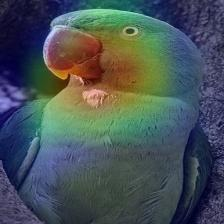

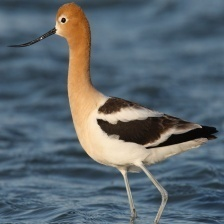

Predicted: [('n02033041', 'dowitcher', 0.55387753)]


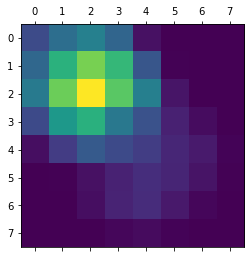

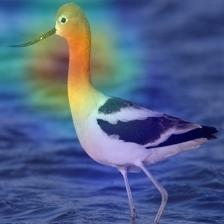

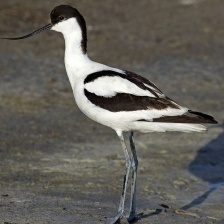

Predicted: [('n01582220', 'magpie', 0.4106313)]


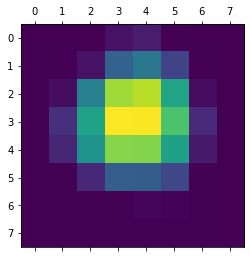

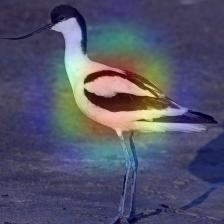

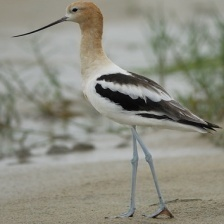

Predicted: [('n02002556', 'white_stork', 0.41593555)]


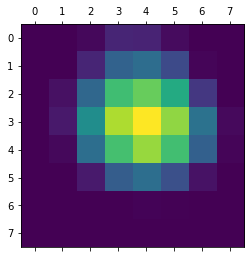

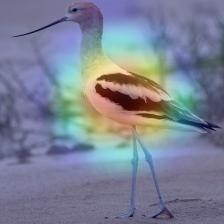

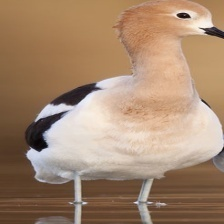

Predicted: [('n02058221', 'albatross', 0.28753766)]


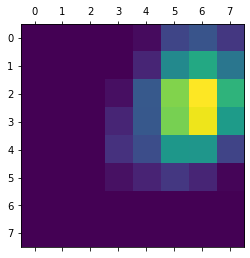

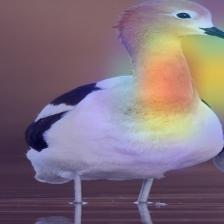

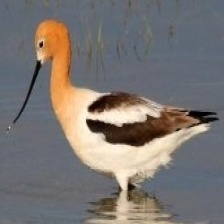

Predicted: [('n02033041', 'dowitcher', 0.35624617)]


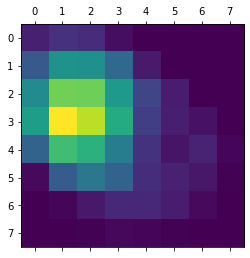

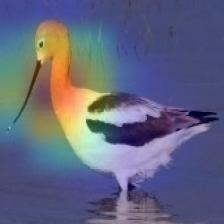

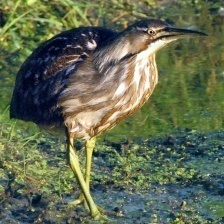

Predicted: [('n02011460', 'bittern', 0.9866948)]


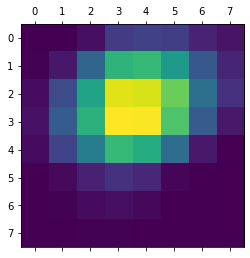

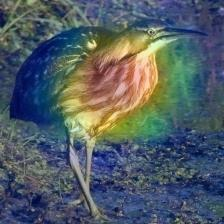

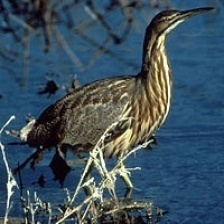

Predicted: [('n02011460', 'bittern', 0.9987924)]


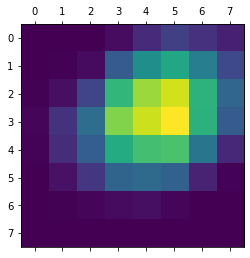

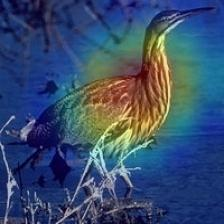

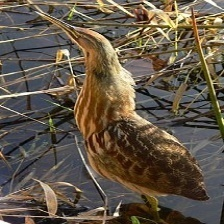

Predicted: [('n02011460', 'bittern', 0.99876297)]


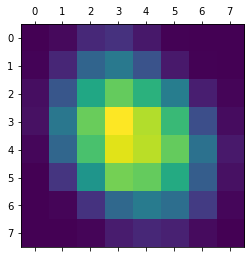

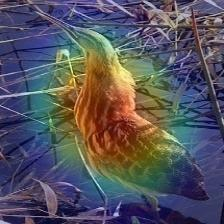

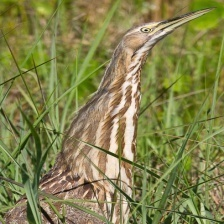

Predicted: [('n02011460', 'bittern', 0.9860153)]


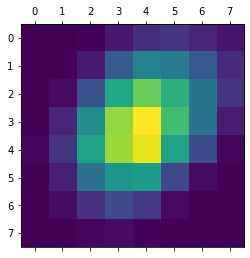

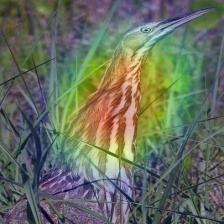

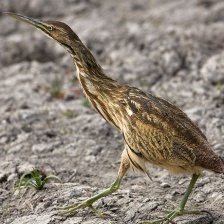

Predicted: [('n02011460', 'bittern', 0.996536)]


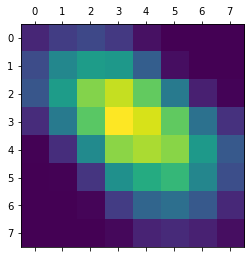

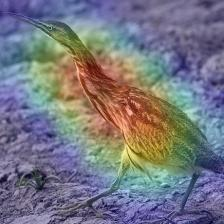

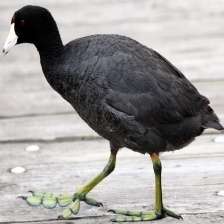

Predicted: [('n02018207', 'American_coot', 0.97947454)]


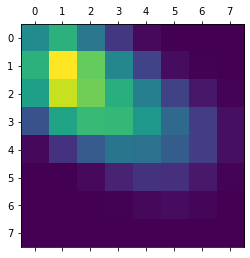

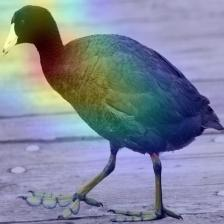

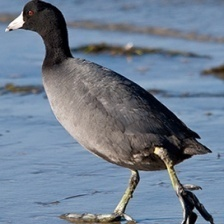

Predicted: [('n02018207', 'American_coot', 0.99932075)]


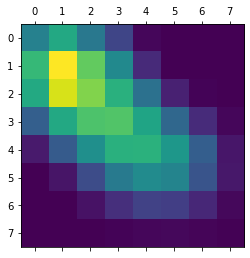

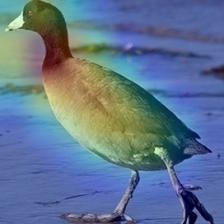

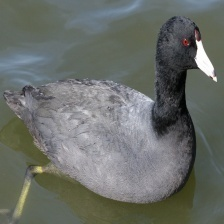

Predicted: [('n02018207', 'American_coot', 0.99955577)]


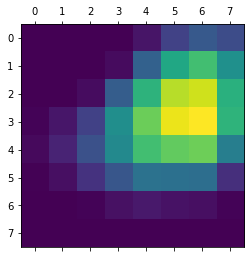

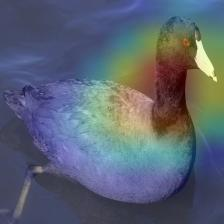

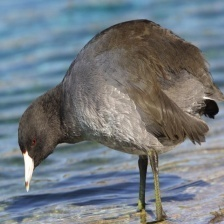

Predicted: [('n02018207', 'American_coot', 0.9987178)]


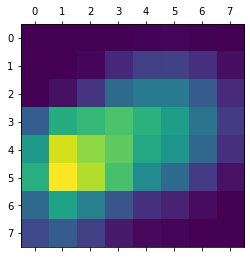

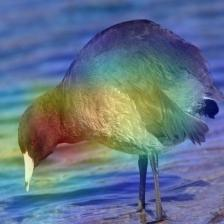

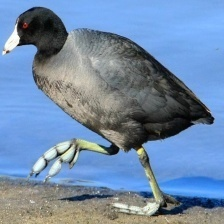

Predicted: [('n02018207', 'American_coot', 0.998042)]


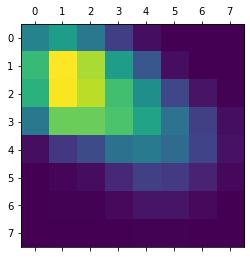

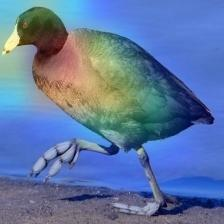

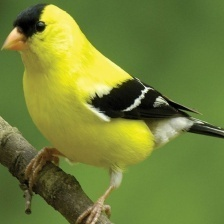

Predicted: [('n01531178', 'goldfinch', 0.99819833)]


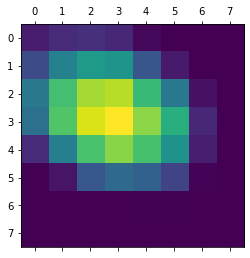

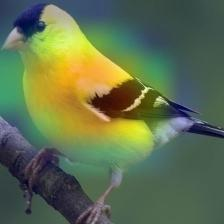

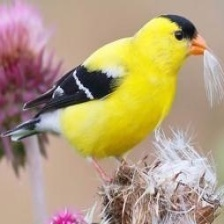

Predicted: [('n01531178', 'goldfinch', 0.9977805)]


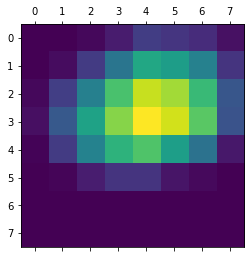

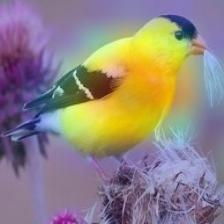

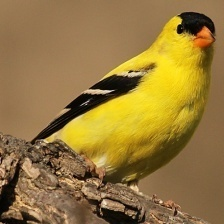

Predicted: [('n01531178', 'goldfinch', 0.99466324)]


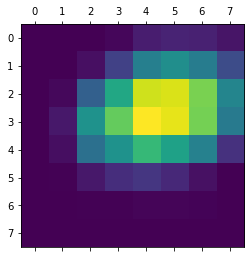

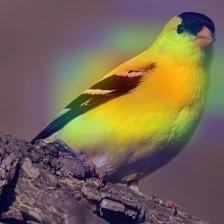

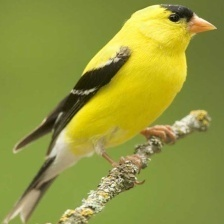

Predicted: [('n01531178', 'goldfinch', 0.9932413)]


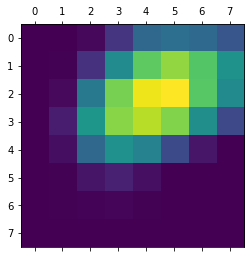

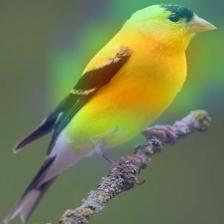

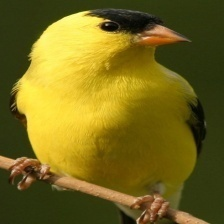

Predicted: [('n01531178', 'goldfinch', 0.9963194)]


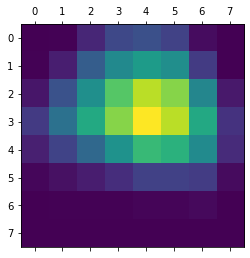

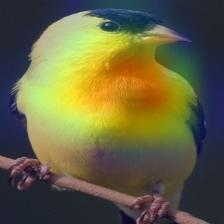

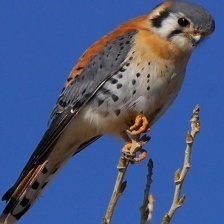

Predicted: [('n01530575', 'brambling', 0.8148045)]


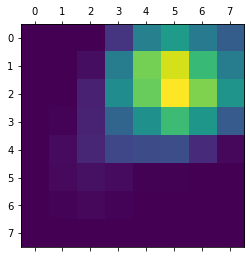

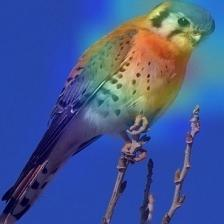

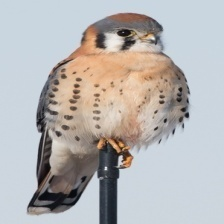

Predicted: [('n01807496', 'partridge', 0.44540003)]


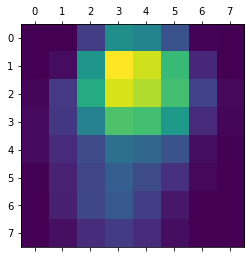

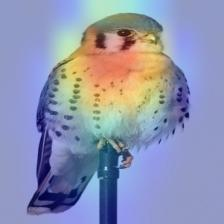

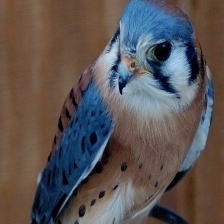

Predicted: [('n01580077', 'jay', 0.98543674)]


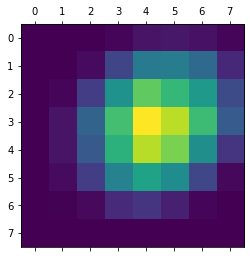

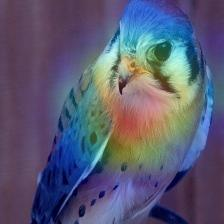

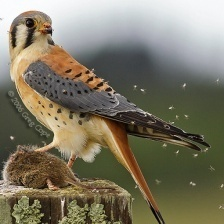

Predicted: [('n01608432', 'kite', 0.9409028)]


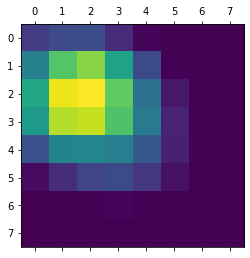

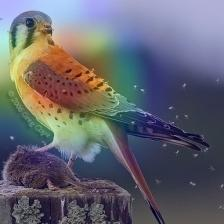

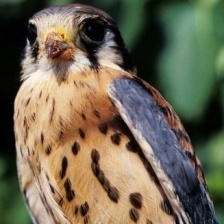

Predicted: [('n01608432', 'kite', 0.5419167)]


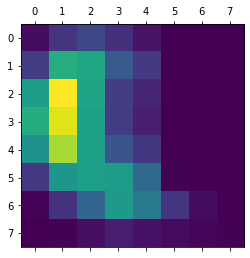

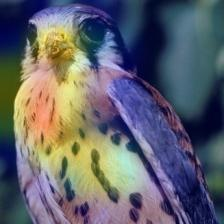

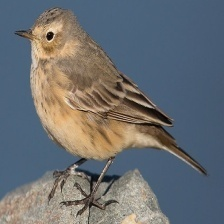

Predicted: [('n01532829', 'house_finch', 0.46108222)]


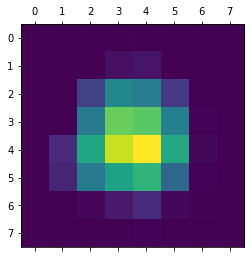

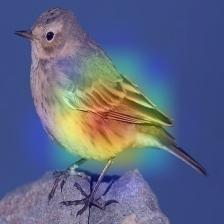

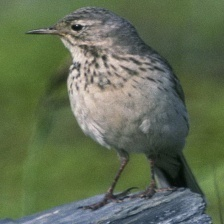

Predicted: [('n01601694', 'water_ouzel', 0.6890078)]


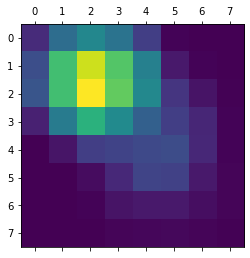

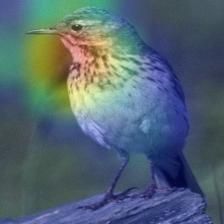

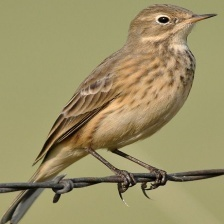

Predicted: [('n01530575', 'brambling', 0.7704299)]


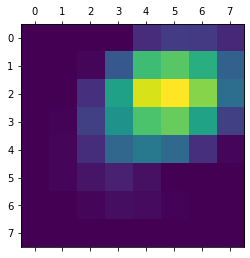

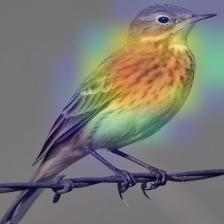

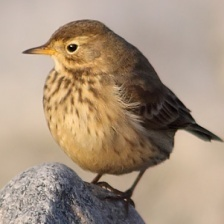

Predicted: [('n01601694', 'water_ouzel', 0.5756038)]


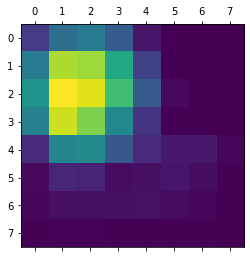

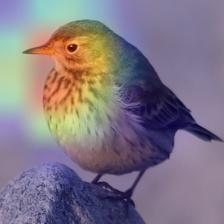

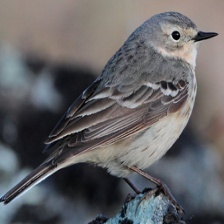

Predicted: [('n01530575', 'brambling', 0.71309507)]


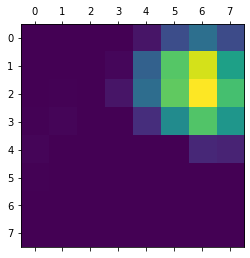

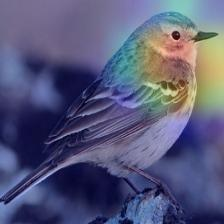

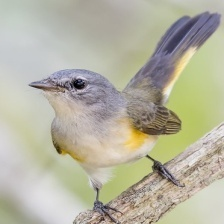

Predicted: [('n01530575', 'brambling', 0.84459317)]


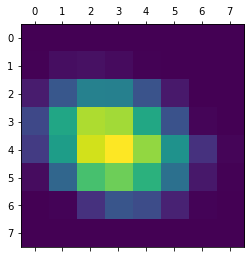

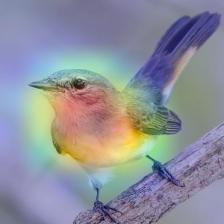

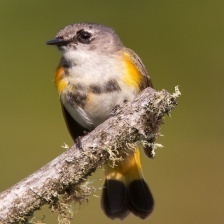

Predicted: [('n01530575', 'brambling', 0.9045495)]


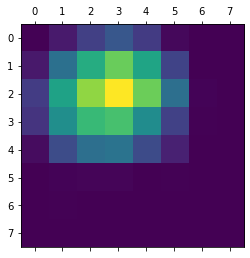

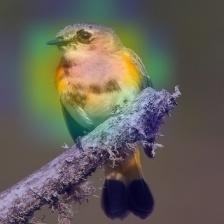

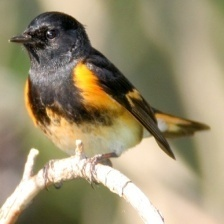

Predicted: [('n01530575', 'brambling', 0.89931315)]


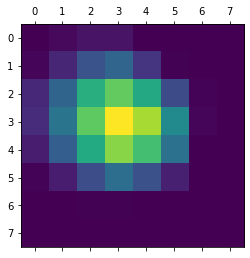

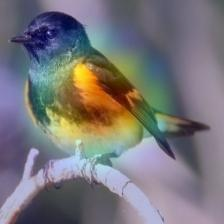

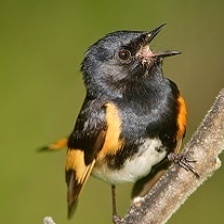

Predicted: [('n01558993', 'robin', 0.79280275)]


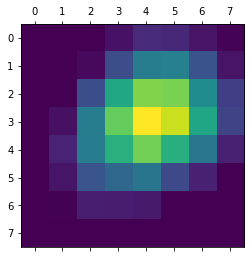

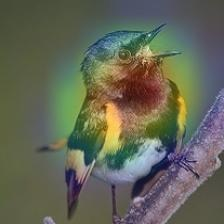

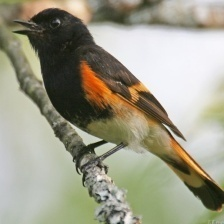

Predicted: [('n01558993', 'robin', 0.5609637)]


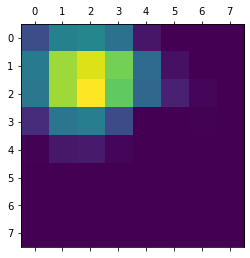

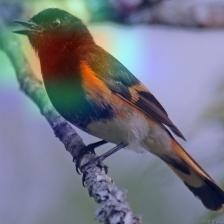

In [17]:
#
for i,b in enumerate(bird_types):
  for j in range(1,6):
    img_path='/content/gdrive/MyDrive/birds/valid/' + b + "/"+ str(j)+'.jpg'

    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    preds = model.predict(img_array)

    heatmap = make_gradcam_heatmap(
        img_array, model, last_conv_layer_name, classifier_layer_names
    )


    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

# combine heatmap with original graph
## color heat map
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

## combine process 
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    save_path = "cam.jpg"
    superimposed_img.save(save_path)

    # Display Grad CAM
    display(Image(save_path))

